In [1]:
import numpy as np
import io
import cv2
from IPython.display import clear_output, Image, display
import PIL.Image

In [14]:
import gerber # https://pcb-tools.readthedocs.io/en/latest/documentation/rs274x.html#functions
stencil = gerber.read('solderpaste_top3.gbr') # read gerber file from eagle or Kicad
bound_x = stencil.bounds[0][1]
bound_y = stencil.bounds[1][1]
print("from gerber mm",bound_x,bound_y," CV Ver:",cv2.__version__)

from gerber mm 60.003 15.019  CV Ver: 4.5.1


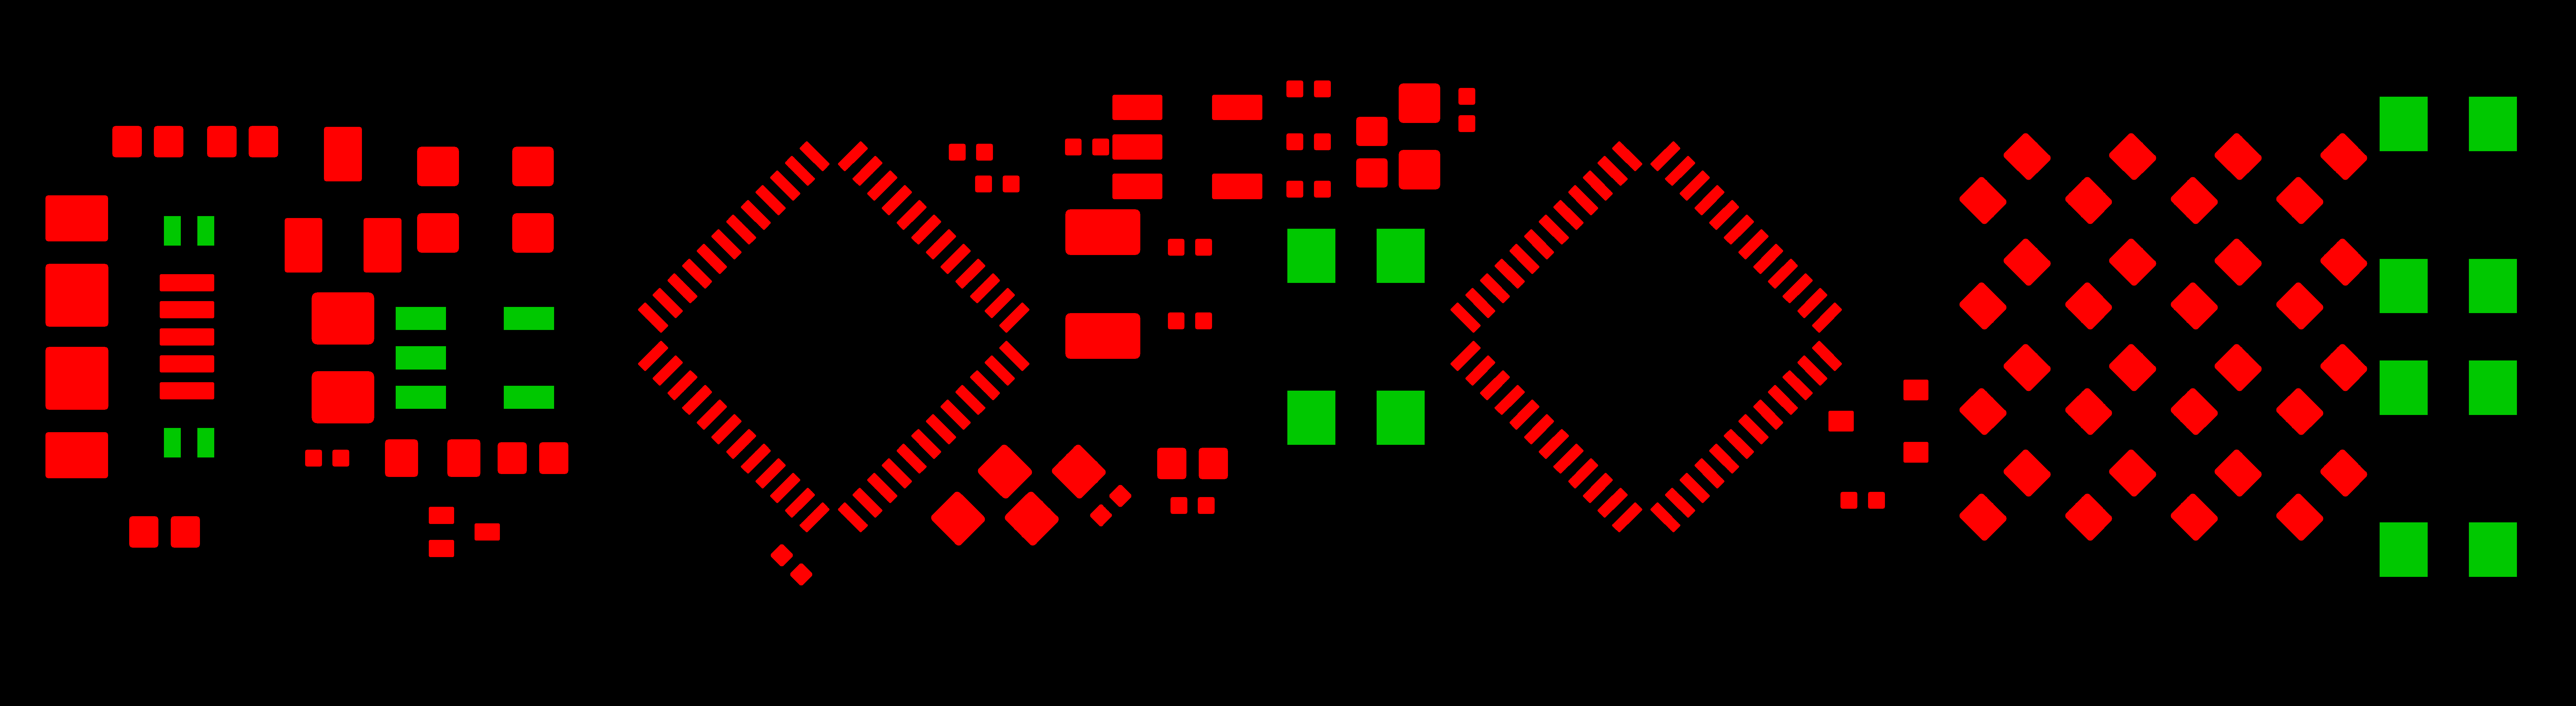

In [15]:
# Helper Function to Draw cv2 images in jupyter
def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
# create a new Image using 128px per mm
height = int(bound_y) * 128 + 256
width  = int(bound_x) * 128 + 256
blank_image = np.zeros((height,width,3), np.uint8)
# draw pads from gerber file
for i in stencil.primitives:
    if isinstance(i,gerber.primitives.Line ): # some elements are simple lines,need also thickness to correct fill 
        p1 = (int(i._start[0] * 128) , int(i._start[1] * 128))
        p2 = (int(i._end[0]   * 128) , int(i._end[1]   * 128) )
        cv2.line(   img=blank_image, pt1=p1,pt2=p2, 
                    color=(255,0,0) , thickness = int(i.aperture._diameter*128) , lineType = 8, shift = 0)
    elif isinstance(i,gerber.primitives.Rectangle ): # draw rectanges
        x1 = int((i._position[0] - i._width * 0.5)  * 128)
        y1 = int((i._position[1] - i._height* 0.5)  * 128)
        x2 = int((i._position[0] + i._width * 0.5)  * 128)
        y2 = int((i._position[1] + i._height* 0.5)  * 128)
        cv2.rectangle(blank_image, (x1,y1), (x2,y2), color=(0,200,0), thickness = -1)
flip_img = cv2.flip(blank_image, -1)
flip_img = cv2.flip(flip_img, 1)
showarray(flip_img)

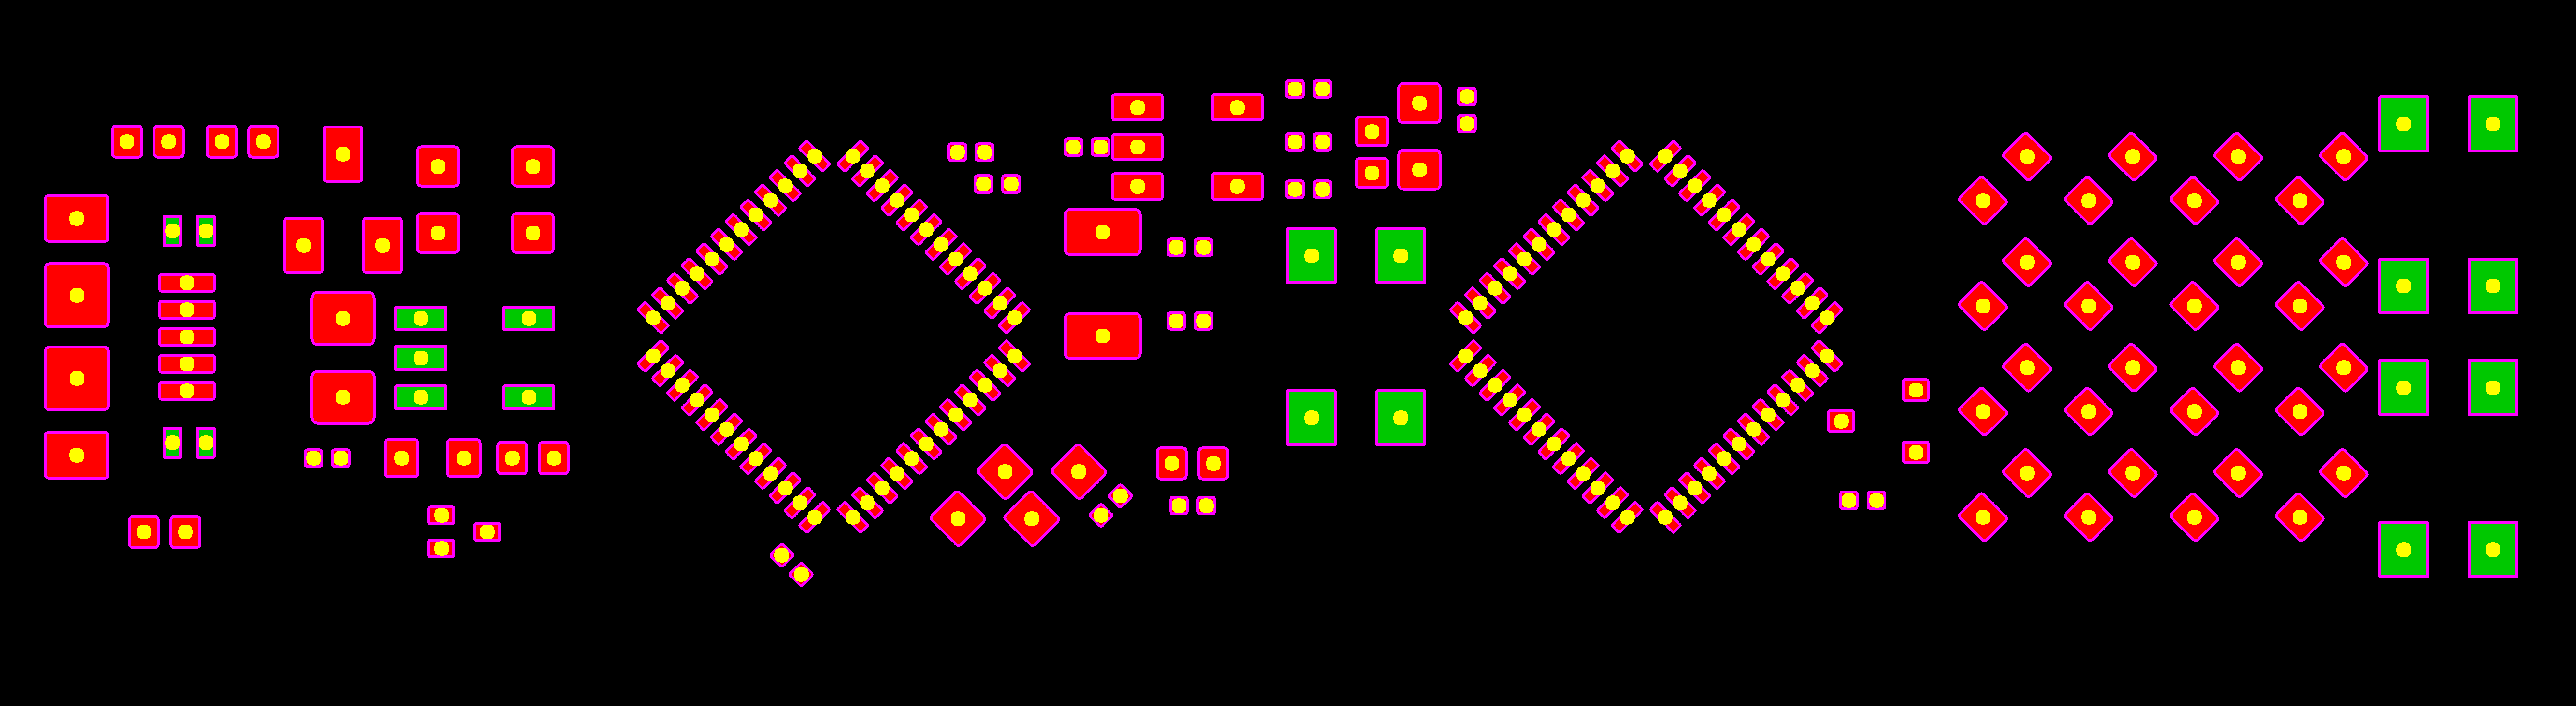

Pad Counter: 228


In [29]:
# found contours to find solder paste points
counter  = 0
imgOrg   = flip_img.copy()  
imgGray  = cv2.cvtColor(flip_img,cv2.COLOR_BGR2GRAY)
contours, hierarchy  = cv2.findContours(imgGray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
csv=""
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    if(x==0 & y==0): continue
    center1 = (x+w//2 -6, y+h//2 -6)
    center2 = (x+w//2 +6, y+h//2 +6)
    csv=csv + "\n" + str(x/128.0) + "," + str(y/128.0)
    cv2.drawContours(imgOrg, contour, -1, (255, 0, 255), 8) # draw outline bounds
    cv2.rectangle(imgOrg, center1, center2, (255, 255, 0), 32) # draw bounds, TODO: add some patterns for bigger pads
    counter=counter+1
showarray(imgOrg)
print("Pad Counter:", counter)

In [30]:
print(csv)


19.015625,13.5625
18.546875,13.1015625
10.3203125,13.0
11.421875,12.6015625
59.421875,12.578125
57.2734375,12.578125
4.109375,12.4296875
3.109375,12.4296875
10.3203125,12.203125
26.234375,12.140625
39.71875,12.09375
38.796875,12.09375
20.1640625,12.09375
19.2421875,12.09375
28.828125,11.96875
28.171875,11.96875
54.78125,11.8828125
52.2421875,11.8828125
49.703125,11.8828125
47.15625,11.8828125
44.9609375,11.84375
44.296875,11.84375
24.1796875,11.8359375
22.40625,11.8359375
40.0703125,11.7421875
38.4453125,11.7421875
20.515625,11.7421875
18.890625,11.7421875
26.6953125,11.671875
40.421875,11.3828125
38.09375,11.3828125
20.8671875,11.3828125
18.53125,11.3828125
40.78125,11.03125
37.7421875,11.03125
21.21875,11.03125
18.1796875,11.03125
8.0,10.828125
7.34375,10.828125
55.84375,10.8203125
53.296875,10.8203125
50.7578125,10.8203125
48.21875,10.8203125
28.8515625,10.78125
27.8515625,10.78125
25.3125,10.703125
23.53125,10.703125
41.1328125,10.6796875
37.3828125,10.6796875
21.578125,10.6796875